In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib

In [2]:
df = pd.read_csv('D:\\Users\\flammmes\\Downloads\\Book1.csv')
df['d']=df['d'].str.replace(',','')
df['Rsob']=df['Rsob'].str.replace(',','')
dfn = pd.read_csv('D:\\Users\\flammmes\\Downloads\\composition.csv')


dd = df.d.astype('float')
df.d = df.d.astype('float')
df['Rsob']= df['Rsob'].astype('float')
df['Rsob']= np.abs(df['Rsob'])
x = df.iloc[:,1]/df.iloc[:,8]
mu = 1000*(df.iloc[:,3]*x*x+df.iloc[:,4]*x+df.iloc[:,5])/(df.iloc[:,6]*x+1)
df.insert(9,'μob',mu)
df.insert(12,'Tr',dfn.Tres)

df = df[df['μob']<=50] 


In [3]:
##strat1
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='median')
#df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)




##strat2
#df.dropna(inplace=True)


##strat3
#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=5, weights="uniform")
#df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)



In [4]:
##strat4
#df.Rsob[df.Rsob==0] = np.nan
df.μob = 1/np.power(df.μob,1/1.5)
my_new = pd.DataFrame({
    'Pb':df.Pb,'μob':df.μob ,'Rs':df.Rsob
})
bb = my_new[my_new['Rs'].isnull().values]
aa = my_new[my_new['Rs'].notnull().values]
dat = aa.iloc[:,0:2].to_numpy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dat =scaler.fit_transform(dat)
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(dat, aa.Rs)

dat2 =bb.iloc[:,0:2].to_numpy()
dat2 =scaler.transform(dat2)
df['Rsob'][df['Rsob'].isnull().values] = forest_reg.predict(dat2)
df.μob = 1/np.power(df.μob,1.5)

df.μob = np.log(df.μob)
my_new = pd.DataFrame({
    'μob':df.μob, 'STO':df.STO
})
bb = my_new[my_new['STO'].isnull().values]
aa = my_new[my_new['STO'].notnull().values]
dat = aa.μob.to_numpy().reshape(-1,1)
scaler2 = StandardScaler()
dat =scaler2.fit_transform(dat)
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(dat, aa.STO)
dat2 = bb.μob.to_numpy().reshape(-1,1)
dat2 =scaler2.transform(dat2)
df['STO'][df['STO'].isnull().values] = lin_reg.predict(dat2)
df.μob = np.exp(df.μob)


my_new = pd.DataFrame({
    'Pb':df.Pb,'Pmax':df.Pmax ,'Rs':df.Rsob,'Tr':df.Tr
})
bb = my_new[my_new['Tr'].isnull().values]
aa = my_new[my_new['Tr'].notnull().values]
dat = aa.iloc[:,0:3].to_numpy()
scaler3 = StandardScaler()
dat =scaler3.fit_transform(dat)
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(dat, aa.Tr)
dat2 =bb.iloc[:,0:3].to_numpy()
dat2 =scaler3.transform(dat2)
df['Tr'][df['Tr'].isnull().values] = forest_reg.predict(dat2)

C:\Users\flammmes\AppData\Local\Temp/ipykernel_13832/794019730.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rsob'][df['Rsob'].isnull().values] = forest_reg.predict(dat2)
C:\Users\flammmes\AppData\Local\Temp/ipykernel_13832/794019730.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STO'][df['STO'].isnull().values] = lin_reg.predict(dat2)
C:\Users\flammmes\AppData\Local\Temp/ipykernel_13832/794019730.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [5]:
df["μob_cat"] = pd.cut(df["μob"],
                               bins=[0., 5, np.inf],
                               labels=[1, 2])

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=3)
for train_index, test_index in split.split(df, df["μob_cat"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [7]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("μob_cat", axis=1, inplace=True)
    #set_.drop("μob", axis=1, inplace=True)
   

C:\Users\flammmes\AppData\Roaming\Python\Python310\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
df1 = strat_train_set.copy()
df2 = strat_test_set.copy()

In [9]:
df1["μob_cat"] = pd.cut(df1["μob"],
                               bins=[0., 5, np.inf],
                               labels=[1, 2])

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=3)
for ti, tei in split.split(df1, df1["μob_cat"]):
    strat_tr_set = df1.iloc[ti]
    strat_val_set = df1.iloc[tei]
    

In [11]:
for set_ in (strat_tr_set, strat_val_set):
    set_.drop("μob_cat", axis=1, inplace=True)
    #set_.drop("μob", axis=1, inplace=True)

C:\Users\flammmes\AppData\Roaming\Python\Python310\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
df_train = strat_tr_set.copy()
df_val = strat_val_set.copy()


In [13]:
def gen_func(a):
    
    dflist = []
    for i in range(len(a)):
        
        
        correlations_select = pd.DataFrame({'P':P_i,'μ':mu_i,'Rsob':instance[10],'API':instance[11],'Tr':instance[12]})
        pressure_bubble_point = correlations_select.iloc[0,0]*np.linspace(1,1,20)
        visc_bubble_point = correlations_select.iloc[0,1]*np.linspace(1,1,20)
        correlations_select.insert(0,"Pb",pressure_bubble_point)
        correlations_select.insert(2,'μob',visc_bubble_point)
        dflist.append(correlations_select)
        
    
    totaldf = pd.concat(dflist)
    totaldf.Pb = totaldf.Pb*145.038
    totaldf.P = totaldf.P*145.038
    totaldf.insert(2,'ΔP', totaldf.P-totaldf.Pb)
    
    totaldf.API = 141.5*1000/totaldf.API -131.5
    totaldf.Rsob = totaldf.Rsob*5.614583333333333
    #totaldf = totaldf[totaldf.μ != totaldf.μob]
    #totaldf.drop('P',axis=1,inplace=True)
    return totaldf

In [14]:
test_data = gen_func(df2)
train_data = gen_func(df_train)
val_data = gen_func(df_val)

#y = test_data[test_data.ΔP==0]
#x =  val_data[val_data.ΔP==0]
#train_data = pd.concat([train_data,y,x])
all_data = gen_func(df)

In [15]:
for a in [test_data,train_data,val_data,all_data]:
    a.μ = np.sqrt(np.log(a.μ/a.μob+0.0012))
    a.ΔP = np.power(a.ΔP,0.5)
    #a.ΔP = np.log(a.ΔP+1)
    #a.insert(0,'x1',a.ΔP*np.power(a.P/a.Pb,0.2))
    a.μob = a.ΔP*np.power(a.μob,0.07)

    #a.insert(4,'logμob',a.μob*np.log(a.μob))
    a.Pb = a.ΔP/np.log(a.Pb+400)
    a.P = a.ΔP*np.power(a.P,-0.15)
    a.API = a.ΔP/np.power(a.API,0.3)
    a.Rsob = a.ΔP/np.log(a.Rsob+150)
    #a.drop('μob',axis=1,inplace=True)
    a.Tr = a.ΔP*np.power(a.Tr,-1.)

In [16]:
corr_matrix = all_data.corr()
corr_matrix["μ"].sort_values(ascending=False)

μ       1.000000
μob     0.893792
API     0.891319
Rsob    0.886864
Pb      0.881542
Tr      0.879285
P       0.877724
ΔP      0.868429
Name: μ, dtype: float64

array([[<AxesSubplot:title={'center':'Pb'}>,
        <AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'ΔP'}>],
       [<AxesSubplot:title={'center':'μob'}>,
        <AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'Rsob'}>],
       [<AxesSubplot:title={'center':'API'}>,
        <AxesSubplot:title={'center':'Tr'}>, <AxesSubplot:>]],
      dtype=object)

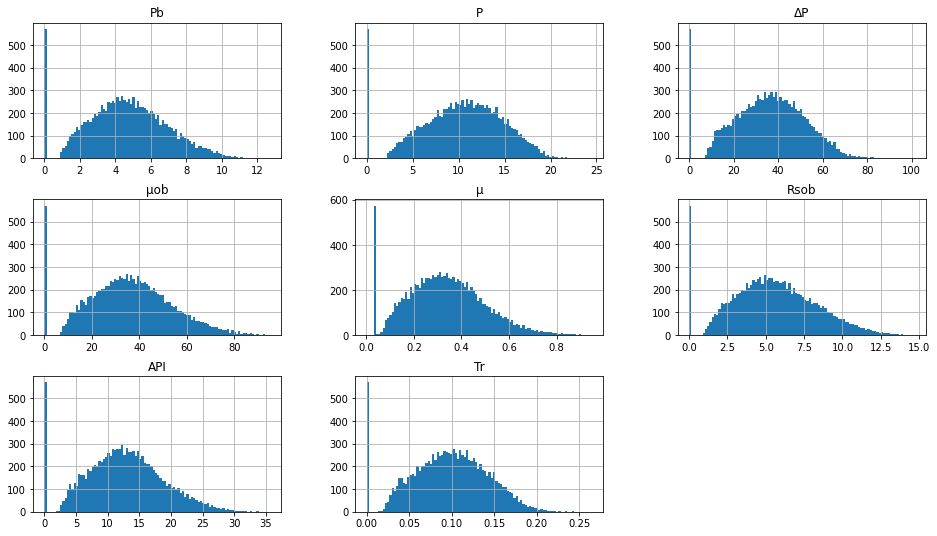

In [17]:
all_data.hist(bins=100,figsize=(16,9))


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

X_train = train_data.drop(["μ"], axis=1) 
y_train = train_data["μ"].copy()
X_val = val_data.drop(["μ"], axis=1) 
y_val = val_data["μ"].copy()
X_test = test_data.drop(["μ"], axis=1) # drop labels for training set
y_test = test_data["μ"].copy()


In [19]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_val_poly = poly_features.fit_transform(X_val)
X_test_poly = poly_features.fit_transform(X_test)
poly_scaler = StandardScaler()
X_train_poly = poly_scaler.fit_transform(X_train_poly)
X_val_poly = poly_scaler.transform(X_val_poly)
X_test_poly = poly_scaler.transform(X_test_poly)


In [20]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_val= scaler.transform(X_val)
X_test= scaler.transform(X_test)


In [21]:
X_features_full = [X_train,X_val,X_test]
X_features_poly_full = [X_train_poly,X_val_poly,X_test_poly]
y_labels_full = [y_train,y_val,y_test]


In [22]:
%store X_features_full
%store X_features_poly_full
%store y_labels_full


Stored 'X_features_full' (list)
Stored 'X_features_poly_full' (list)
Stored 'y_labels_full' (list)


In [23]:
totaldf_full = gen_func(df2)
%store totaldf_full
totaldf_full
all_data_full = gen_func(df)
%store all_data_full

Stored 'totaldf_full' (DataFrame)
Stored 'all_data_full' (DataFrame)


In [24]:
scaler.mean_

array([ 4.73480618, 10.45996323, 36.05279401, 36.44620067,  5.59370402,
       12.77004143,  0.09816896])

In [25]:
scaler.var_

array([5.29100268e+00, 2.05784009e+01, 2.81406809e+02, 3.15476005e+02,
       7.68736219e+00, 3.86796612e+01, 2.05977533e-03])